In [19]:
#==============================================================================
# Gamaliel Marines Olvera - A01708746
# 
# TC2008B. Sistemas Multiagente
# Actividad Integradora: Simulación de un sistema multiagente
#==============================================================================


# Import libraries
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import numpy as np
import random

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Set a seed value for random number generation
random.seed(67890)

In [20]:

#==============================================================================
# Box agent
#
# This agent is only used to be able to identify the box as a neighbor
# The agent has a type of 1, which helps us identify it as a box
##==============================================================================

class Box(Agent):
    # Constructor
    # @param unique_id: unique identifier for the agent
    # @param model: the model in which the agent is located
    # @return: none
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = 1

In [21]:


#==============================================================================
# Robot agent
#
# This agent is the one that will perform the tasks we are looking for.
# This can only move in 4 directions but can search for boxes in 8 directions.
# It has the ability to carry one box at a time and take it to a tower. In the same way
# communicates with the other agents of its type to be able to perform searches
# boxes and towers more efficiently. They communicate to tell each other
# which are their towers so that others do not carry boxes there.
#==============================================================================


class Robot(Agent):
    # Constructor
    # @param unique_id: unique identifier for the agent
    # @param model: the model in which the agent is located
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = 2  # Type to identify the agent
        self.box_carried = False  # Flag to know if it is carrying a box
        self.box_carried_id = None  # ID of the carried box
        self.has_tower = False  # Flag to know if it has a tower
        self.tower_flag = False  # Flag to know if it is searching for a tower
        self.tower_dest_coord = None  # Coordinates of the tower it is searching for    
        self.tower_coord = None  # Coordinates of the tower it has
        self.box_flag = False  # Flag to know if it is searching for a box
        self.box_coord = None  # Coordinates of the box it is searching for


    
    # Function to find the nearest box
    # among all known boxes that are not towers
    def findNearestBox(self):
        distances = []
        # Iterate through all grid coordinates and their contents
        for (contents, (x, y)) in self.model.grid.coord_iter():
            # Check if there is a Box in the contents
            if any(isinstance(c, Box) for c in contents):
                # Calculate the distance between the agent and the box
                distance = self.calculate_distance(self.pos, (x, y))
                distances.append((distance, (x, y)))

        filtered_distances = []  # Distances that are not towers
        for distance in distances:
            if distance[1] in self.model.towers:
                continue
            else:
                filtered_distances.append(distance)
        filtered_distances.sort(key=lambda tup: tup[0])

        if len(filtered_distances) > 0:
            return filtered_distances[0][1]
        else:
            self.moveRandom()

    
    # Function to calculate the Manhattan distance between two points
    def calculate_distance(self, pos_agent, pos_box):
        x1, y1 = pos_agent
        x2, y2 = pos_box
        # Calculate and return the Manhattan distance
        return abs(x1 - x2) + abs(y1 - y2)

    # Function to move to a box
    def move2box(self, box_pos):
        # If no position is provided
        if box_pos is None:
            self.moveRandom()
            return

        x, y = self.pos
        target_x, target_y = box_pos

        # If already at the position
        if self.pos == box_pos:
            self.moveRandom()
            return

        # Potential new position
        new_x, new_y = x, y

        # Adjust the new position based on the relative distance to the target
        if abs(x - target_x) > abs(y - target_y):
            if x < target_x:
                new_x += 1
            elif x > target_x:
                new_x -= 1
        else:
            if y < target_y:
                new_y += 1
            elif y > target_y:
                new_y -= 1

        # Check if the new position is occupied by a Box
        new_position_contents = self.model.grid.get_cell_list_contents((new_x, new_y))
        if any(isinstance(agent, Box) for agent in new_position_contents):
            self.moveRandom()
            return

        # Move the agent to the new position
        self.model.grid.move_agent(self, (new_x, new_y))


    # Function to move randomly
    def moveRandom(self):
        # Get possible steps around the current position
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        possible_steps_list = list(possible_steps)

        # Remove steps that are occupied by a Box
        for step in possible_steps_list:
            if self.model.boxes[step[0]][step[1]] != 0:
                possible_steps_list.remove(step)

        # Choose a random position from the remaining possibilities
        new_position = random.choice(possible_steps_list)
        # Move the agent to the selected position
        self.model.grid.move_agent(self, new_position)

    # Function to search for a tower
    def look4tower(self):
        # Get neighbors of the agent
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        has_box = False
        # Check if there is a Box among the neighbors
        for neighbor in neighbors:
            if isinstance(neighbor, Box):
                has_box = True
        if has_box:
            # Call to mark a tower among the neighbors if there is a box
            self.markTower()
        else:
            # Search for the nearest box if there is no box
            if not self.tower_flag:
                nearest_tower_pos = self.findNearestBox()
                self.move2box(nearest_tower_pos)
            else:
                self.move2box(self.tower_dest_coord)


    # Function to mark a tower
    # Search for the tower with the most boxes among the neighbors
    # If it is not marked, mark it
    # If all towers are marked, search for the nearest tower
    def markTower(self):
        possibles = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)

        # Get Neighbors Positions
        positions = set()
        for possible in possibles:
            pos = possible.pos
            positions.add(pos)

        positions = list(positions)
        positions_to_keep = []
        for pos in positions:
            if pos not in self.model.towers:
                positions_to_keep.append(pos)

        positions = positions_to_keep

        # Get the highest box count from neighbors
        if len(positions) > 0:
            count = 0
            tower_pos = None
            for position in positions:
                box_count = self.model.boxes[position[0]][position[1]]
                if box_count > count:
                    count = box_count
                    tower_pos = position
                    self.tower_coord = tower_pos

            # Mark the tower
            self.has_tower = True
            self.model.towers.append(tower_pos)
        else:
            if not self.tower_flag:
                nearest_tower_pos = self.findNearestBox()
                self.move2box(nearest_tower_pos)
            else:
                self.move2box(self.tower_dest_coord)

    # Function to search for a box
    def look4Box(self): 
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        box_neighbor = []

        for neighbor in neighbors:
            if isinstance(neighbor, Box):
                box_neighbor.append(neighbor)

        box_coords = []
        for box in box_neighbor:
            box_coords.append(box.pos)

        box_coords = list(set(box_coords))
        for tower in self.model.towers:
            if tower in box_coords:
                box_coords.remove(tower)

        if len(box_coords) > 0:
            box_pos = random.choice(box_coords)
            box = self.model.grid.get_cell_list_contents([box_pos])[0]
            self.model.pick_box(box.pos)
            self.box_carried_id = box.unique_id
            self.box_carried = True

        else:
            if not self.box_flag:
                nearest_box_pos = self.findNearestBox()
                self.box_flag = True
                self.box_coord = nearest_box_pos
                self.move2box(nearest_box_pos)
            else:
                self.move2box(self.box_coord)


    # Function to check if the tower has been completed and remove it
    def checkTower(self):
        if self.model.boxes[self.tower_coord[0]][self.tower_coord[1]] == 5:
            self.has_tower = False
            self.tower_coord = None

    # Function to move to a tower
    def move2tower(self):
        # Check if there are no more available towers
        if self.tower_coord is not None:
            x1, y1 = self.pos
            x2, y2 = self.tower_coord

            # Check if the agent is adjacent to the tower
            if (x1 + 1 == x2 or x1 - 1 == x2) and (y1 + 1 == y2 or y1 - 1 == y2):
                self.model.drop_box(self.tower_coord, self.box_carried_id)
                self.checkTower()
                self.box_carried = False
                self.has_locked_box = False
                self.box_flag = False
                self.box_coord = None
                return

            # Check if the agent is on the same row as the tower
            if (x1 + 1 == x2 or x1 - 1 == x2) and y1 == y2:
                self.model.drop_box(self.tower_coord, self.box_carried_id)
                self.checkTower()
                self.box_carried = False
                self.has_locked_box = False
                self.box_flag = False
                self.box_coord = None
                return

            # Check if the agent is on the same column as the tower
            if (y1 + 1 == y2 or y1 - 1 == y2) and x1 == x2:
                self.model.drop_box(self.tower_coord, self.box_carried_id)
                self.checkTower()
                self.box_carried = False
                self.has_locked_box = False
                self.box_flag = False
                self.box_coord = None
                return

            # Move the agent towards the tower
            if x1 < x2:
                x1 += 1
                self.model.grid.move_agent(self, (x1, y1))
                return
            elif x1 > x2:
                x1 += -1
                self.model.grid.move_agent(self, (x1, y1))
                return
            elif y1 < y2:
                y1 += 1
                self.model.grid.move_agent(self, (x1, y1))
                return
            elif y1 > y2:
                y1 += -1
                self.model.grid.move_agent(self, (x1, y1))
                return
        else:
            return

    # Step function to define agent behavior at each time step
    def step(self):
        # If the agent has no box and no tower
        if not self.box_carried and not self.has_tower:
            self.look4tower()
        # If the agent has no box and has a tower
        elif not self.box_carried and self.has_tower:
            self.look4Box()
        # If the agent has a box and has a tower
        elif self.box_carried and self.has_tower:
            self.move2tower()


In [22]:
# Function to obtain the grid of the simulation for visualization
def get_grid(model):
    grid = np.zeros((model.width, model.height))
    for (contents, (x, y)) in model.grid.coord_iter():
        for content in contents:
            # If it is a box
            if isinstance(content, Box):
                grid[x][y] = model.boxes[x][y]  # Number of boxes
            # If it is a robot
            elif isinstance(content, Robot):
                grid[x][y] = 10  # Value to identify it
    return grid


In [23]:
#===================================================================
#
# The model is the "space" or the ambience where the agents will
# interact.
#
# The model is the core of the simulation. It contains the grid,
# schedule, and data collector objects, and it is responsible for
# stepping the model through time.
# 
# The model is instantiated with the following parameters:
# width: width of the grid
# height: height of the grid
# num_agents: number of agents in the simulation
# num_boxes: number of boxes in the simulation
#
# Additionally, it contains functions to
# place agents on the grid, check if a cell is empty,
# check if a cell has a box, check if a tower is full,
# pick up a box, drop a box, get a random position,
# get a random cell, get a random position, check if
# the simulation is finished, and advance one step.
#===================================================================

class WarehouseModel(Model):
    def __init__(self, width, height, num_agents, num_boxes):
        # Constants
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.num_boxes = num_boxes
        self.random.seed(67890)

        # Variables used by agents
        self.boxes = np.zeros((width, height))
        self.known_boxes = np.zeros((width, height))
        self.towers = []

        # Model-exclusive variables
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        # Simulation variables
        self.steps = 0

        # Place robots
        robotId = 0
        robot_positions = []  # Robot positions
        for _ in range(self.num_agents):
            a = Robot(robotId, self)
            self.schedule.add(a)
            pos = self.random_empty_cell()
            while self.is_box(pos):
                pos = self.random_empty_cell()
            robot_positions.append(pos)
            self.grid.place_agent(a, pos)
            robotId += 1

        # Place boxes
        boxId = 10
        for _ in range(self.num_boxes):
            b = Box(boxId, self)
            self.schedule.add(b)
            pos = self.random_box_cell(robot_positions)
            while self.init_full(pos):
                pos = self.random_box_cell(robot_positions)
            self.grid.place_agent(b, pos)
            self.boxes[pos[0]][pos[1]] += 1
            boxId += 1

    # Function to check if a cell has a box
    def is_box(self, pos):
        return self.boxes[pos[0]][pos[1]] > 0

    # Function to check if a cell has 3 boxes
    def init_full(self, pos):
        return self.boxes[pos[0]][pos[1]] == 3

    # Function to check if a tower is full
    def is_tower_full(self, pos):
        return self.boxes[pos[0]][pos[1]] == 5

    # Agent function to pick up a box
    def pick_box(self, pos):
        self.boxes[pos[0]][pos[1]] -= 1
        self.grid.remove_agent(self.grid.get_cell_list_contents(pos)[0])

    # Agent function to drop a box
    def drop_box(self, pos, unique_id):
        b = Box(unique_id, self)
        self.boxes[pos[0]][pos[1]] += 1
        self.grid.place_agent(b, pos)

    # Function used by boxes to get a random position during creation
    def random_box_cell(self, robot_pos):
        empty_cells = [(x, y) for x in range(self.width) for y in range(self.height)]
        available_cells = [cell for cell in empty_cells if cell not in robot_pos]
        if not available_cells:
            raise Exception("No empty cells available.")
        return random.choice(available_cells)

    # Function used by robots to get a random empty position
    def random_empty_cell(self):
        empty_cells = [(x, y) for x in range(self.width) for y in range(self.height) if self.grid.is_cell_empty((x, y))]
        if not empty_cells:
            raise Exception("No empty cells available.")
        return random.choice(empty_cells)

    # Function to check if the simulation is finished
    def is_simulation_done(self):
        # A range because sometimes agents mark a tower and don't fill it
        if len(self.towers) in range(40, 45):
            return True
        else:
            return False

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        if not self.is_simulation_done():
            self.steps += 1


In [24]:
# Constants
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5
NUM_BOXES = 200


In [25]:
# Create a WarehouseModel instance with specified parameters
model = WarehouseModel(WIDTH, HEIGHT, NUM_AGENTS, NUM_BOXES)

# Run the simulation for 350 steps
for i in range(350):
    model.step()

# Collect and store simulation data
data = model.datacollector.get_model_vars_dataframe()


37


/var/folders/hx/jdv9z5kj44b5b90287xxdb1w0000gn/T/ipykernel_37538/1613994828.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(data.iloc[0][0], cmap=plt.cm.binary)
/var/folders/hx/jdv9z5kj44b5b90287xxdb1w0000gn/T/ipykernel_37538/1613994828.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(data.iloc[frame][0])


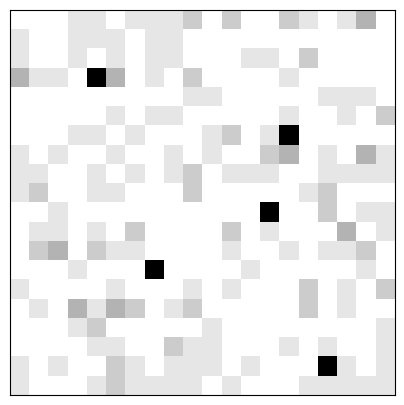

In [26]:
# Create a subplot for visualization
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])

# Display the initial state of the simulation
patch = plt.imshow(data.iloc[0][0], cmap=plt.cm.binary)

# Animation function to update the display for each frame
def animate(frame):
    patch.set_data(data.iloc[frame][0])

# Run the animation for 350 frames with a 100-millisecond interval
steps = model.steps
print(len(model.towers))
anim = animation.FuncAnimation(fig, animate, frames=350, interval=100)


In [27]:
print("Steps: ", model.steps)
anim

/var/folders/hx/jdv9z5kj44b5b90287xxdb1w0000gn/T/ipykernel_37538/1613994828.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(data.iloc[frame][0])


Steps:  350
